In [2]:
import numpy as np
import matplotlib.pyplot as plt

from poisson_solver_v2 import poisson_solve
from zero_form import ZeroForm
from one_form import OneForm

from visualizer import visualize_1form_with_colors

In [55]:
L = 1.0
N = 2 ** 5
h = (L / N)

# Create the array of vertices, xyz indexing.
V_ind = np.asarray([[[[i,j,k] for k in range(N)] for j in range(N)] for i in range(N)])
V = V_ind * h
V.shape

(32, 32, 32, 3)

In [75]:
def curve_function(t: float):
    return np.array([0.5, 0.5, 0.5]) + 0.5 * np.array([np.cos(2 * np.pi * t), np.sin(2 * np.pi * t), np.sin(2 * np.pi * t) * 0.00])

t_range = np.linspace(0, 1, 16)
curve_data = np.array([curve_function(t) for t in t_range])
curve_data

array([[1.        , 0.5       , 0.5       ],
       [0.95677273, 0.70336832, 0.5       ],
       [0.8345653 , 0.87157241, 0.5       ],
       [0.6545085 , 0.97552826, 0.5       ],
       [0.44773577, 0.99726095, 0.5       ],
       [0.25      , 0.9330127 , 0.5       ],
       [0.0954915 , 0.79389263, 0.5       ],
       [0.0109262 , 0.60395585, 0.5       ],
       [0.0109262 , 0.39604415, 0.5       ],
       [0.0954915 , 0.20610737, 0.5       ],
       [0.25      , 0.0669873 , 0.5       ],
       [0.44773577, 0.00273905, 0.5       ],
       [0.6545085 , 0.02447174, 0.5       ],
       [0.8345653 , 0.12842759, 0.5       ],
       [0.95677273, 0.29663168, 0.5       ],
       [1.        , 0.5       , 0.5       ]])

In [76]:
def levi_civita_symbol(i, j, k):
    denominator = abs(j - i) * abs(k - i) * abs(k - j)
    numerator = (j - i) * (k - i) * (k - j)

    if denominator == 0:
        return 0
    return numerator / denominator

# Brute force calculation for combinations which have \epsilon_{i, j, k} = 1
total_permutations = []
for i in range(3):
    permutations = []
    for j in range(3):
        for k in range(3):
            if levi_civita_symbol(i, j, k) == 1:
                permutations.append([j, k])
    total_permutations.append(permutations)
total_permutations = [el[0] for el in total_permutations]
total_permutations

[[1, 2], [2, 0], [0, 1]]

In [ ]:
def SignedIntersection(Γ, f):
    """
    Compute the flux-weighted signed intersection of a discrete curve segment with a finite rectangular grid face,
    ensuring that the final sum is properly normalized.

    Parameters:
    Γ (list of tuples): List of curve points [(x1, y1, z1), (x2, y2, z2), ...].
    f (tuple): (v, e_i, size) where:
        - v (tuple): Base vertex defining the face (x, y, z).
        - e_i (int): Normal direction index (0=x,1=y,2=z).
        - size (tuple): Size of the face in the two perpendicular directions.

    Returns:
    (tuple) containing
    float: Net flux-weighted signed intersection value, constrained to [-1,1].
    int: The number of crossings
    """
    v, e_i, size = f  # Extract face properties
    normal_axis = e_i  # The axis normal to the face
    
    # Define the normal vector of the face
    face_normal = np.zeros(3)
    face_normal[normal_axis] = 1  # Example: If normal is in the Z direction, it's (0,0,1)

    # Get the two axes defining the plane of the face
    #other_axes = [0, 1, 2]
    #other_axes.remove(normal_axis)  # Get the two remaining coordinate axes
    #j, k = other_axes  # These define the face’s 2D plane
    
    # TODO: Take into account the levi-civita symbols!
    j, k = total_permutations[e_i]
    
    # Compute face boundaries based on size
    face_min = np.array([v[j], v[k]])  # Min corner in (j,k) plane
    face_max = face_min + np.array(size)  # Max corner in (j,k) plane
    
    total_flux = 0.0  # Accumulate weighted signed contributions
    crossing_count = 0  # Track number of valid crossings

    for segment_index in range(len(Γ) - 1):
        p1 = np.array(Γ[segment_index])
        p2 = np.array(Γ[segment_index + 1])

        # Extract coordinate values along the normal direction
        coord1, coord2 = p1[normal_axis], p2[normal_axis]
        face_coord = v[normal_axis]  # The face coordinate in this direction

        # Check if the segment crosses the plane of the face
        if (coord1 < face_coord and coord2 > face_coord) or (coord1 > face_coord and coord2 < face_coord):
            
            # Compute intersection point
            t = (face_coord - coord1) / (coord2 - coord1)  
            intersection = p1 + t * (p2 - p1)  
            intersection_2d = np.array([intersection[j], intersection[k]])

            # Check if the intersection lies within the finite face
            if np.all(face_min <= intersection_2d) and np.all(intersection_2d <= face_max):
                
                # Compute curve tangent at intersection
                curve_tangent = (p2 - p1) / np.linalg.norm(p2 - p1) 

                # Compute projection of tangent onto face normal
                flux_contribution = np.dot(curve_tangent, face_normal)
                
                total_flux += flux_contribution
                crossing_count += 1  
    
    return (total_flux, crossing_count)


In [78]:
# Test Case: Multiple crossings with different angles
Γ_test = [
    (0.5, 0.5, -0.5),  # Before first intersection
    (0.5, 0.5, 0.5),   # Perpendicular through the face (should contribute fully)
    (0.5, 1.0, 0.5),
    (0.5, 0.25, 0.5),
]

# Face at vertex (0,0,0) with normal along Z-axis (e_i = 2), size (1.0 x 1.0) in X and Y
f_test = ((0, 0, 0), 2, (1.0, 1.0))

# Run the test
flux_result = SignedIntersection(Γ_test, f_test)
flux_result

(np.float64(1.0), 1)

In [79]:
# Compute delta_Gamma form as a discrete array
delta_gamma = np.zeros_like(V).astype(float)
num_crossings = np.zeros_like(V_ind)
Nx, Ny, Nz, _ = V_ind.shape
for x in range(Nx):
    for y in range(Ny):
        for z in range(Nz):
            for i in range(3):
                face = (V[x, y, z], i, (h, h))
                flux, n_crossings = SignedIntersection(curve_data, face)
                delta_gamma[x, y, z, i] = flux
                num_crossings[x, y, z, i] = n_crossings


## Visualization of intersection data

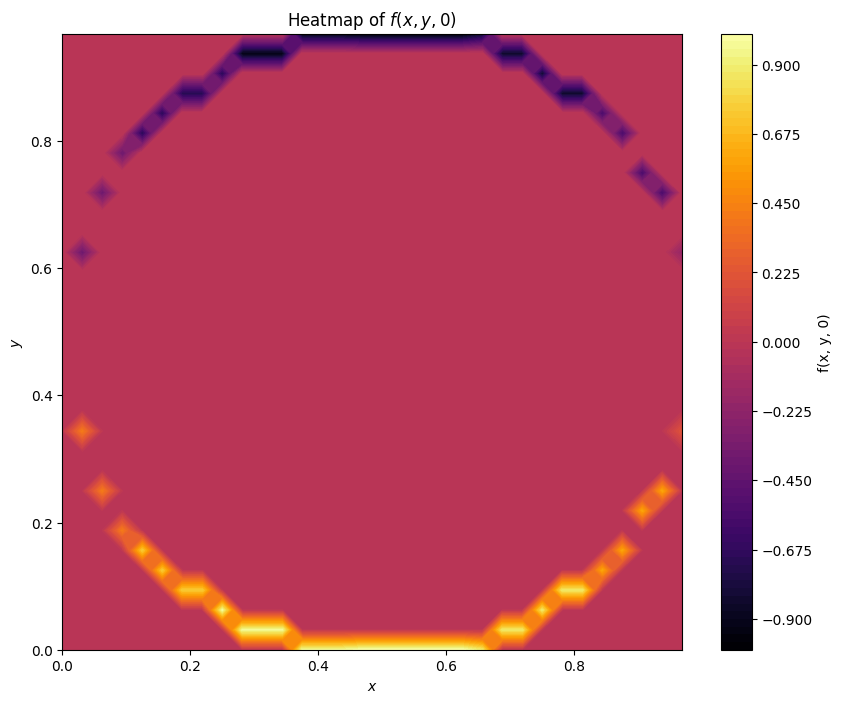

In [80]:
fig = plt.subplots(1, 1, figsize=(10, 8))
plt.contourf(V[:, :, 0, 0], V[:, :, 0, 1], delta_gamma[:, :, N // 2, 0], levels=80, cmap='inferno')
plt.colorbar(label='f(x, y, 0)')
plt.title('Heatmap of $f(x, y, 0)$')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

Solve the poisson problems related to Biot-Savart field problem.

In [81]:
Psi_0 = poisson_solve(ZeroForm(V_ind, scalar_field=delta_gamma[..., 0]))
Psi_1 = poisson_solve(ZeroForm(V_ind, scalar_field=delta_gamma[..., 1]))
Psi_2 = poisson_solve(ZeroForm(V_ind, scalar_field=delta_gamma[..., 2]))

Psi = np.asarray([Psi_0, Psi_1, Psi_2])
Psi.shape

(3, 32, 32, 32)

## Visualize Psi vector fields

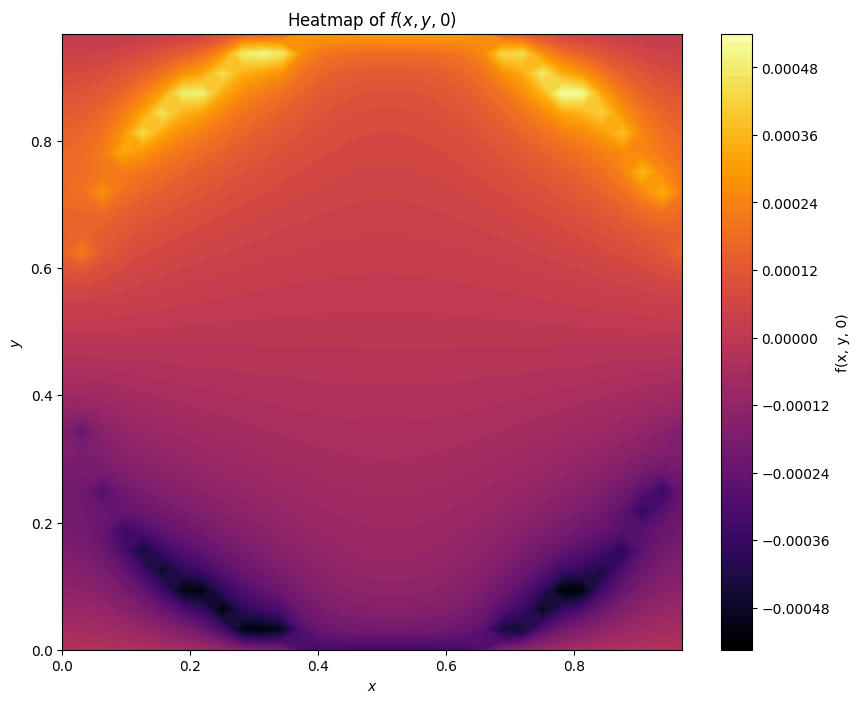

In [82]:
fig = plt.subplots(1, 1, figsize=(10, 8))
plt.contourf(V[:, :, 0, 0], V[:, :, 0, 1], Psi_0[:, :, N // 2], levels=80, cmap='inferno')
plt.colorbar(label='f(x, y, 0)')
plt.title('Heatmap of $f(x, y, 0)$')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

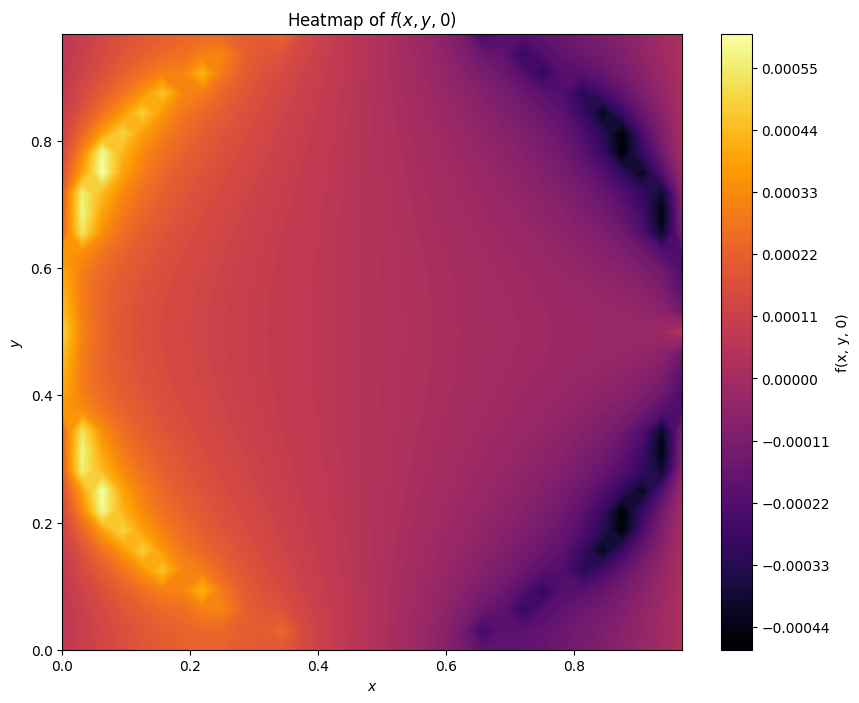

In [83]:
fig = plt.subplots(1, 1, figsize=(10, 8))
plt.contourf(V[:, :, 0, 0], V[:, :, 0, 1], Psi_1[:, :, N // 2], levels=128, cmap='inferno')
plt.colorbar(label='f(x, y, 0)')
plt.title('Heatmap of $f(x, y, 0)$')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

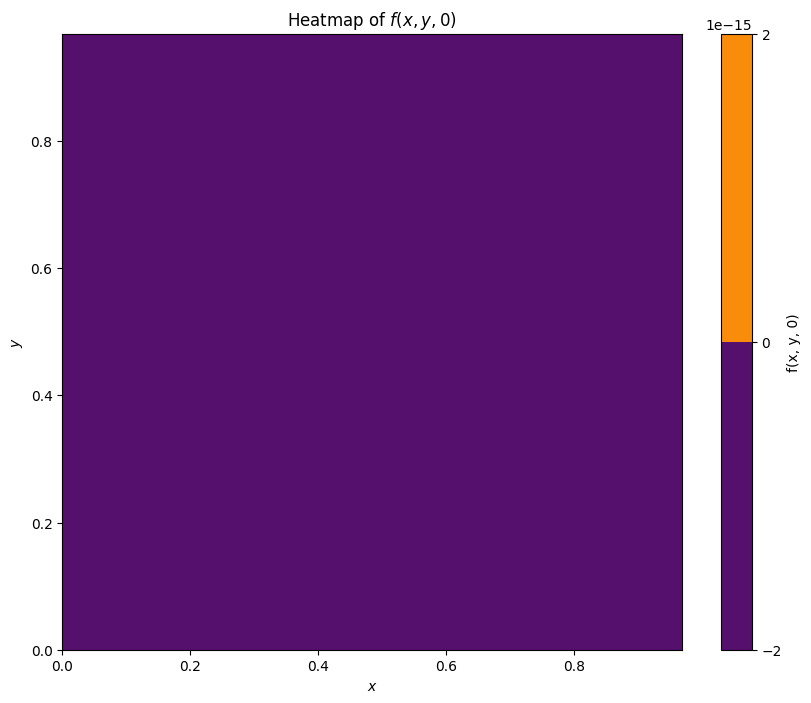

In [84]:
fig = plt.subplots(1, 1, figsize=(10, 8))
plt.contourf(V[:, :, 0, 0], V[:, :, 0, 1], Psi_2[:, :, N // 2], levels=128, cmap='inferno')
plt.colorbar(label='f(x, y, 0)')
plt.title('Heatmap of $f(x, y, 0)$')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

# Calculation of $\tilde{\eta}_0$

In [85]:
def levi_civita_symbol(i, j, k):
    denominator = abs(j - i) * abs(k - i) * abs(k - j)
    numerator = (j - i) * (k - i) * (k - j)

    if denominator == 0:
        return 0
    return numerator / denominator

# Brute force calculation for combinations which have \epsilon_{i, j, k} = 1
total_permutations = []
for i in range(3):
    permutations = []
    for j in range(3):
        for k in range(3):
            if levi_civita_symbol(i, j, k) == 1:
                permutations.append([j, k])
    total_permutations.append(permutations)
total_permutations = [el[0] for el in total_permutations]
total_permutations

[[1, 2], [2, 0], [0, 1]]

In [86]:
Nx, Ny, Nz = Psi.shape[1:]
k_space = [np.fft.fftfreq(Nx), np.fft.fftfreq(Ny), np.fft.fftfreq(Nz)]
kx, ky, kz = np.meshgrid(k_space[0], k_space[1], k_space[2], indexing="ij")

# Compute Fourier transform of Psi along spatial dimensions
Psi_hat = np.fft.fftn(Psi, axes=(1, 2, 3))

# Gaussian Low-Pass Filter
sigma = 0.1  # Adjust this for stronger or weaker smoothing

# Initialize eta_0 in Fourier space
eta_0_hat = np.zeros_like(Psi_hat, dtype=np.complex128)

# Apply differentiation operator in Fourier space
eta_0_hat[0] = 2j * np.pi * (ky * Psi_hat[2] - kz * Psi_hat[1])  # x-component
eta_0_hat[1] = 2j * np.pi * (kz * Psi_hat[0] - kx * Psi_hat[2])  # y-component
eta_0_hat[2] = 2j * np.pi * (kx * Psi_hat[1] - ky * Psi_hat[0])  # z-component

filter_gaussian = np.exp(- (kx**2 + ky**2 + kz**2) / (2 * sigma**2))
eta_0_hat *= filter_gaussian  # Apply filter in Fourier space
# Transform back to spatial domain
eta_0 = np.fft.ifftn(eta_0_hat, axes=(1, 2, 3)).real  # Take only real part

# Reshape to have the last axis as the vector components
eta_0 = np.moveaxis(eta_0, 0, -1)  # Now shape is (Nx, Ny, Nz, 3)

# Now eta_0 has shape (Nx, Ny, Nz, 3) as desired
print(eta_0.shape)  # Should print (Nx, Ny, Nz, 3)

(32, 32, 32, 3)


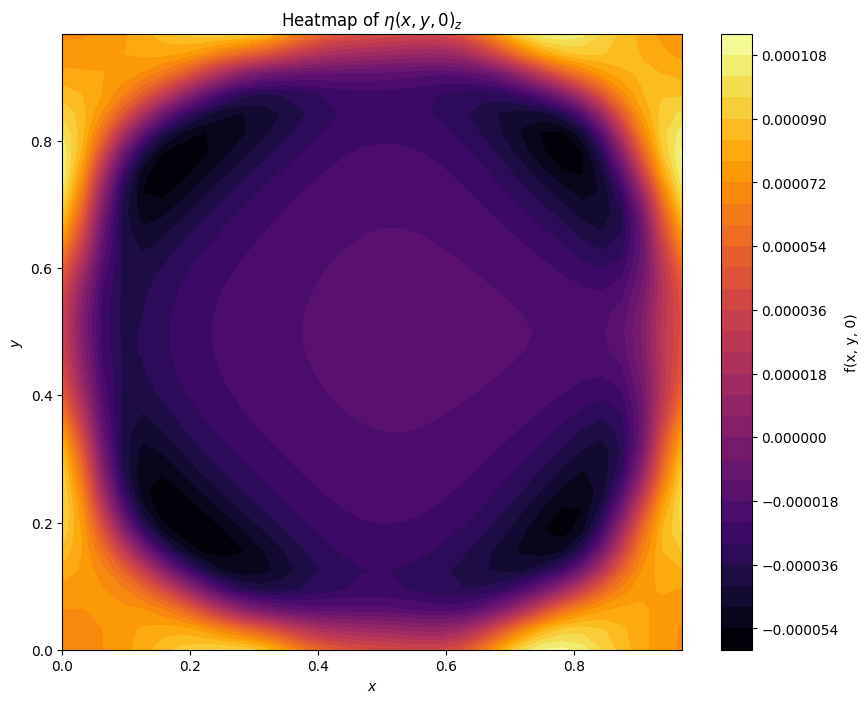

In [88]:
fig = plt.subplots(1, 1, figsize=(10, 8))
plt.contourf(V[:, :, 0, 0], V[:, :, 0, 1], eta_0[:, :, N // 2, 2], levels=32, cmap='inferno')

plt.colorbar(label='f(x, y, 0)')
plt.title('Heatmap of $\eta(x, y, 0)_z$')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

<Axes3D: >

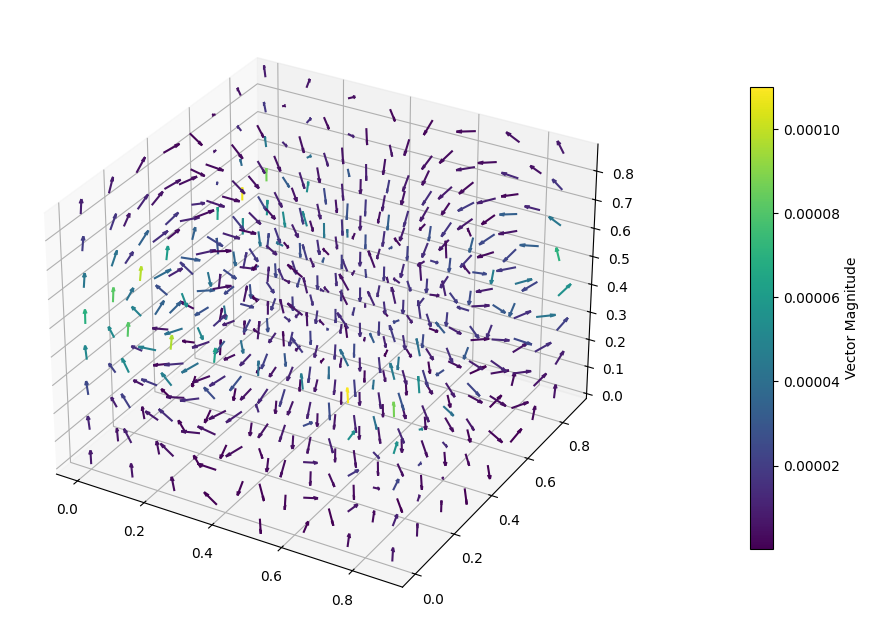

In [89]:
ax = plt.figure(figsize=(16, 8)).add_subplot(projection = '3d')
eta_0_form = OneForm(mesh_indices=V_ind.copy(), vector_field=eta_0)
visualize_1form_with_colors(ax, V, eta_0_form, length=0.05, stride=N // 8)

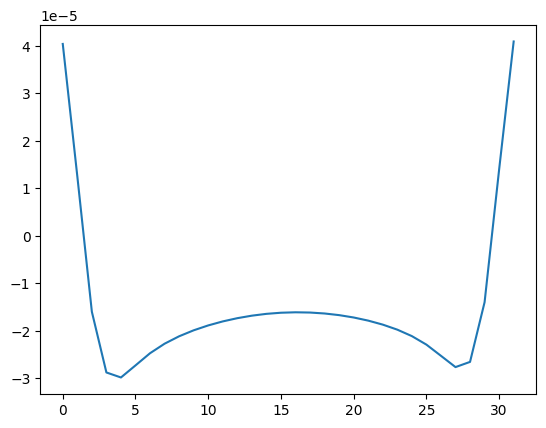

In [90]:
plt.plot(eta_0[N // 2, :, N // 2, 2])

# Area correction

In [36]:
%reload_ext autoreload
%autoreload 2

In [37]:
from compute_area import compute_area_vector

In [38]:
A = compute_area_vector(t_values=t_range, curve_function=curve_function)
A

array([-2.45245904e-02,  7.51713506e-18,  2.20721314e-01])

In [39]:
area_error_term = A[:]
# Stupid way of doing this:
for x in range(Nx):
    for y in range(Ny):
        for z in range(Nz):
            for i in range(3):
                e_i = np.zeros_like(A)
                e_i[i] = eta_0[x, y, z, i]
                area_error_term = area_error_term - e_i


# Calculation of $\eta_0$ and $\mathbf{X}_0$

In [40]:
eta_0_proper = np.zeros_like(eta_0)
for x in range(Nx):
    for y in range(Ny):
        for z in range(Nz):
            for i in range(3):
                eta_0_proper[x, y, z, i] = eta_0[x, y, z, i] + area_error_term[i]
eta_0_proper.shape

(64, 64, 64, 3)

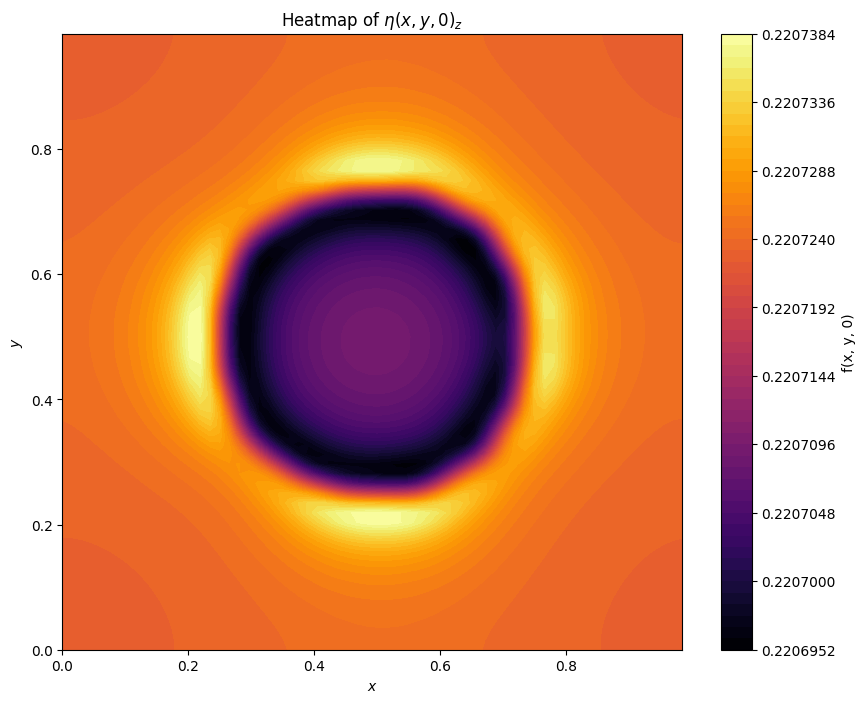

In [41]:
fig = plt.subplots(1, 1, figsize=(10, 8))
plt.contourf(V[:, :, 0, 0], V[:, :, 0, 1], eta_0_proper[:, :, N // 2 -1, 2].real, levels=64, cmap='inferno')

plt.colorbar(label='f(x, y, 0)')
plt.title('Heatmap of $\eta(x, y, 0)_z$')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

In [42]:
X_0 = np.zeros_like(eta_0_proper)
for x in range(Nx):
    for y in range(Ny):
        for z in range(Nz):
            for i in range(3):
                pos = np.array([x, y, z])
                diff = np.zeros_like(pos)
                diff[i] = -1
                prev_pos = (pos + diff) % shapes[i]
                X_0[x, y, z, i] = 1 / (2 * h) * (eta_0_proper[x, y, z, i] - eta_0_proper[prev_pos[0], prev_pos[1], prev_pos[2], i])

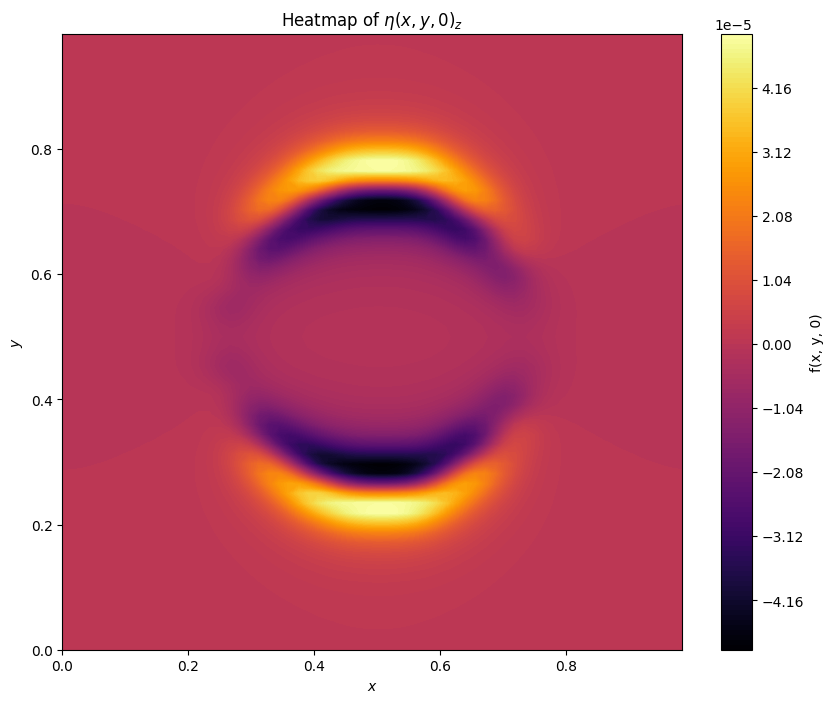

In [54]:
fig = plt.subplots(1, 1, figsize=(10, 8))
plt.contourf(V[:, :, 0, 0], V[:, :, 0, 1], X_0[:, :, N // 2, 1].real, levels=128, cmap='inferno')

plt.colorbar(label='f(x, y, 0)')
plt.title('Heatmap of $\eta(x, y, 0)_z$')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

In [28]:

first_guess_form = OneForm(V_ind, vector_field=X_0.copy())

<Axes3D: >

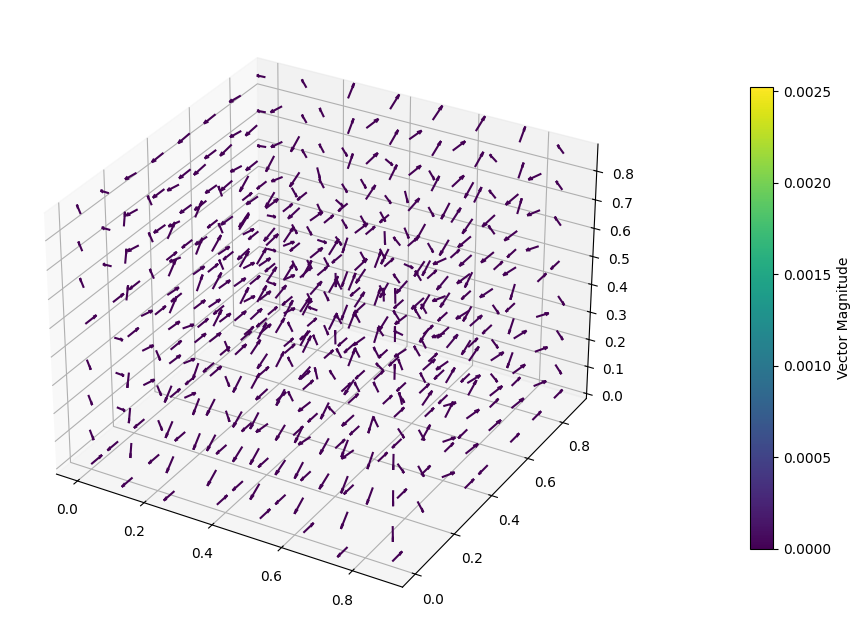

In [44]:
ax = plt.figure(figsize=(16, 8)).add_subplot(projection = '3d')
visualize_1form_with_colors(ax, V, first_guess_form, length=0.05, stride=N // 8)

In [45]:
X_0

array([[[[-2.99452657e-08, -3.02015153e-08,  0.00000000e+00],
         [-8.97668412e-08, -9.05339399e-08,  1.20142788e-07],
         [-1.49377099e-07, -1.50650083e-07,  2.40004188e-07],
         ...,
         [ 1.49377099e-07,  1.50650083e-07, -3.59285025e-07],
         [ 8.97668412e-08,  9.05339399e-08, -2.40004188e-07],
         [ 2.99452657e-08,  3.02015153e-08, -1.20142788e-07]],

        [[-3.00929260e-08, -3.00926798e-08,  0.00000000e+00],
         [-9.02111187e-08, -9.02083908e-08,  1.19991526e-07],
         [-1.50121846e-07, -1.50110706e-07,  2.39708019e-07],
         ...,
         [ 1.50121846e-07,  1.50110706e-07, -3.58856646e-07],
         [ 9.02111187e-08,  9.02083908e-08, -2.39708019e-07],
         [ 3.00929260e-08,  3.00926798e-08, -1.19991526e-07]],

        [[-3.05354138e-08, -2.97538371e-08,  0.00000000e+00],
         [-9.15424949e-08, -8.91946469e-08,  1.19970911e-07],
         [-1.52353738e-07, -1.48430459e-07,  2.39681957e-07],
         ...,
         [ 1.52353738e-0

In [46]:
np.save('./data/X_0.npy', arr = X_0)